In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy

import numpy as np
import pandas as pd
import sqlalchemy as sqa

from jax.random import PRNGKey
import jax.numpy as jnp
from jax import random

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, log_likelihood

import pystarboard.data_spacescope as data_spacescope
import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.date_utils as date_utils
import mechafil.data as d
import mechafil_jax.constants as C
import mechafil.data_spacescope as dss
import scenario_generator.utils as u
import cel_utils.disk_utils as du

In [3]:
save_dir = os.path.join(os.environ['HOME'], 'Documents', 'direct_filp_v2')
offline_dir = os.path.join(save_dir, 'offline')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_dir, exist_ok=True)

In [4]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
lock_target = 0.3
forecast_length = 365*3
sector_duration = 540

current_date = date(2023, 12, 1)
mo = current_date.month - 2  # get 2 mo historical data to get better estimate of gas burn
if mo == 0: mo = 1
start_date = date(current_date.year, mo, 1)
end_date = current_date + timedelta(days=forecast_length)

print(start_date, current_date, end_date)

2023-10-01 2023-12-01 2026-11-30


In [5]:
@du.cache_data(offline_dir)
def get_offline_data():
    offline_data = data.get_simulation_data(token, start_date, current_date, end_date)
    t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=365*2), current_date)
    t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=365*2), current_date+timedelta(days=1))
    t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=365*2), current_date+timedelta(days=1))
    
    return {
        'offline_data': offline_data,
        't_hist_rbp': t_hist_rbp,
        'hist_rbp': hist_rbp,
        't_hist_rr': t_hist_rr,
        'hist_rr': hist_rr,
        't_hist_fpr': t_hist_fpr,
        'hist_fpr': hist_fpr
    }

od = get_offline_data()
locals().update(od)

In [6]:
smooth_historical_rbp = np.median(hist_rbp[-30:])
smooth_historical_rr = np.median(hist_rr[-30:])
smooth_historical_fpr = np.median(hist_fpr[-30:])

print(smooth_historical_rbp, smooth_historical_rr, smooth_historical_fpr)

3.936737060546875 0.595636067195692 0.9500188129379901


In [7]:
rbp = jnp.ones(forecast_length) * smooth_historical_rbp
rr = jnp.ones(forecast_length) * smooth_historical_rr
fpr = jnp.ones(forecast_length) * smooth_historical_fpr

simulation_results = sim.run_sim(
    rbp,
    rr,
    fpr,
    lock_target,

    start_date,
    current_date,
    forecast_length,
    sector_duration,
    offline_data
)

In [18]:
scaling_vec = [0.75, 1.5, 3, 6.5]
scale2results = {}
for sc in scaling_vec:
    rbp = jnp.ones(forecast_length) * smooth_historical_rbp * sc
    rr = jnp.ones(forecast_length) * smooth_historical_rr
    fpr = jnp.ones(forecast_length) * smooth_historical_fpr
    
    simulation_results_scaled = sim.run_sim(
        rbp,
        rr,
        fpr,
        lock_target,
    
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    scale2results[sc] = simulation_results_scaled

In [19]:
smooth_historical_rbp, smooth_historical_rr, smooth_historical_fpr

(3.936737060546875, 0.595636067195692, 0.9500188129379901)

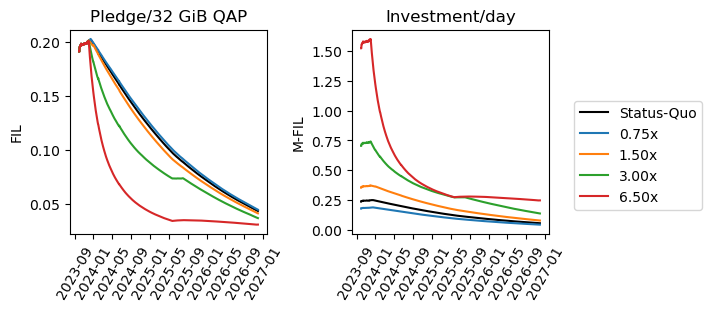

In [24]:
# plt.figure(figsize=(9,3))
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(7,3), layout='constrained')
t = date_utils.get_t(start_date, end_date=end_date)

axx = ax[0]
SECTORS_PER_PIB = C.PIB / C.SECTOR_SIZE
axx.plot(t, simulation_results['day_pledge_per_QAP'], color='k', label='Status-Quo')
for sc in scaling_vec:
    axx.plot(t, scale2results[sc]['day_pledge_per_QAP'], label='%0.02fx' % (sc,))
# plt.legend()
axx.set_title('Pledge/32 GiB QAP')
axx.set_ylabel('FIL')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[1]
SECTORS_PER_PIB = C.PIB / C.SECTOR_SIZE
qa_sector_factor = smooth_historical_fpr * 10
axx.plot(t, simulation_results['day_pledge_per_QAP'] * SECTORS_PER_PIB * smooth_historical_rbp * qa_sector_factor / 1e6, color='k')
for sc in scaling_vec:
    axx.plot(t, scale2results[sc]['day_pledge_per_QAP'] * SECTORS_PER_PIB * smooth_historical_rbp * sc * qa_sector_factor / 1e6)
axx.set_title('Investment/day')
axx.set_ylabel('M-FIL')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

fig.legend(loc='outside right center')
plt.savefig(os.path.join(save_dir, 'onboarding_vs_investment.png'))

In [26]:
scaling_vec = np.linspace(1, 7, 100)
total_investment_vec = np.zeros_like(scaling_vec).astype(float)
for ii, sc in enumerate(scaling_vec):
    rbp = jnp.ones(forecast_length) * smooth_historical_rbp * sc
    rr = jnp.ones(forecast_length) * smooth_historical_rr
    fpr = jnp.ones(forecast_length) * smooth_historical_fpr
    
    simulation_results_scaled = sim.run_sim(
        rbp,
        rr,
        fpr,
        lock_target,
    
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    total_investment = np.sum(simulation_results_scaled['day_pledge_per_QAP'] * SECTORS_PER_PIB * smooth_historical_rbp * sc)
    total_investment_vec[ii] = total_investment

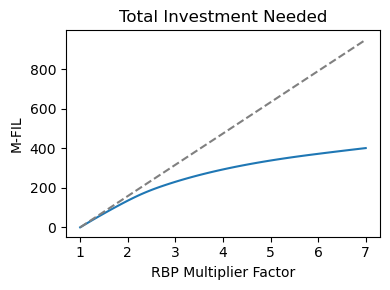

In [28]:
# len(total_investment_vec), len(scaling_vec)
# plt.figure(scaling_vec, total_investment_vec)
plt.figure(figsize=(4,3))
plt.plot(scaling_vec, (total_investment_vec - total_investment_vec[0])/1e6 * qa_sector_factor, label='Total Investment')
plt.plot(scaling_vec, (total_investment_vec[0]*scaling_vec-total_investment_vec[0])/1e6 * qa_sector_factor, linestyle='--', color='grey', label='Linear Reference')
plt.ylabel('M-FIL')
plt.xlabel('Onboarding Multiplier Factor')
plt.title('Total Investment Needed')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'onboarding_vs_investment_cumulative.png'))

In [13]:
SECTORS_PER_PIB

32768.0

In [16]:
.2*SECTORS_PER_PIB*4

262144.0